<a href="https://colab.research.google.com/github/HasanKhadd0ur/ColaTraining/blob/main/notebooks/RL/LunarLanderLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning - Lunar Lander

In this assignment, you will train an agent to land a lunar lander safely on a landing pad on the surface of the moon.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay
!sudo apt-get install xvfb
!pip install xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import PIL.Image
import tensorflow as tf
# from drive.MyDrive import  utils
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam


In [ ]:
env = gym.make('LunarLander-v3', render_mode="rgb_array")

In [ ]:
!cp drive/MyDrive/utils.py .

In [ ]:
import utils

In [ ]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

In [ ]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

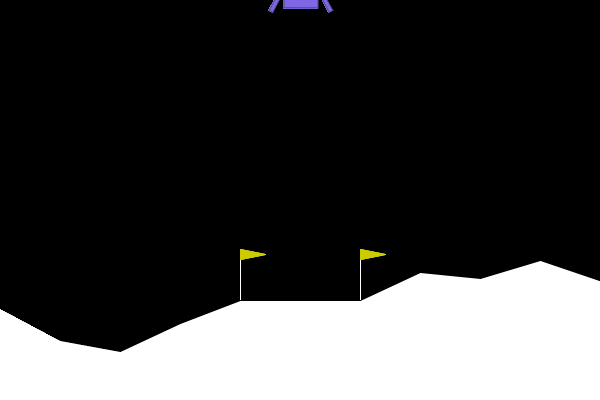

In [ ]:
init, _ = env.reset()
PIL.Image.fromarray(env.render())

<a name="3"></a>
## 3 - The Lunar Lander Environment

The goal of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and its center is at coordinates `(0,0)` but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if you get `200` points.

<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The absolute value of the lander's $x$-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

You can check out the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) for a full description of the environment.

In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [ ]:
# Reset the environment and get the initial state.
current_state = env.reset()

In [ ]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _, _ = env.step(action)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

In [ ]:
# Create the Q-Network
q_network = Sequential([
    Input(state_size,type=np.float),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_actions,activation='linear')
])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(state_size,type=np.float),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_actions,activation='linear')
])


optimizer = Adam()


In [ ]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).

    y_targets = rewards * done_vals +(1-done_vals) * (rewards + gamma * max_qsa)

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    loss = MSE(y_tragets,max_qsa)

    return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state, _ = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -160.37
Episode 200 | Total point average of the last 100 episodes: -118.08
Episode 300 | Total point average of the last 100 episodes: -73.78
Episode 400 | Total point average of the last 100 episodes: -8.00
Episode 500 | Total point average of the last 100 episodes: 149.39
Episode 584 | Total point average of the last 100 episodes: 199.40

Episode 585 | Total point average of the last 100 episodes: 203.12

Environment solved in 585 episodes!

Total Runtime: 1899.68 s (31.66 min)


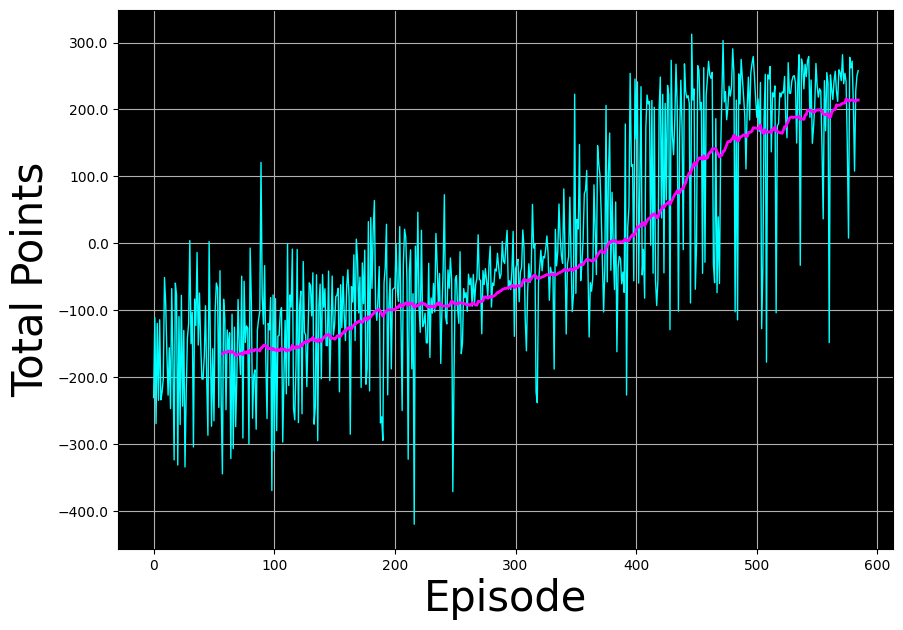

In [ ]:
# Plot the total point history along with the moving average
utils.plot_history(total_point_history)

In [ ]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
q_network = tf.keras.models.load_model("./drive/MyDrive/lunar_lander_model.h5")

In [ ]:
filename = "./drive/MyDrive/videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)